### Chain Using LangGraph 

In this section we will see how we can build a simple chain using LangGraph that uses 4 important concepts 

- how to use chat messages as out graph state
- how to use chat models in graph nodes 
- how to bind tools to our llm in chat models 
- how to execute the tools call in our graph nodes

In [4]:
from dotenv import load_dotenv
import os 
load_dotenv(dotenv_path="../.env")

from langchain_groq import ChatGroq 

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API")


### How to use chat messages as our graph state 

#### Messages 

we can use messages which can be used to capture different roles within a conversation. LangChain has variour messages types including HumanMessage, AlMessage , SystemMessage and toolMessage. These represent a messages from the user , from chat model, for the chat model to instruct behavior , and from a tool call.

Every message have these important components 

- content - content of the message 
- name - specify the name of author 
- response_metadata - optionally , a dict of metadata(eg: often populated by model provider for AlMessages)



In [ ]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint
from rich import print

messages=[AIMessage(content=f"please tell me how can i help.",name="LLM")]
messages.append(HumanMessage(content=f"I want to learn coding",name="abhijit"))
messages.append(AIMessage(content=f"tell me which programming language you want to learn ? ",name="LLM"))
messages.append(HumanMessage(content="I want to learn python programming language.",name="abhijit"))
print(messages)


[
    AIMessage(content='please tell me how can i help.', additional_kwargs={}, response_metadata={}, name='LLM'),
    HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='abhijit'),
    AIMessage(
        content='tell me which programming language you want to learn ? ',
        additional_kwargs={},
        response_metadata={},
        name='LLM'
    ),
    HumanMessage(
        content='I want to learn python programming language.',
        additional_kwargs={},
        response_metadata={},
        name='abhijit'
    )
]

In [6]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

please tell me how can i help.
================================ Human Message =================================
Name: abhijit

I want to learn coding
================================== Ai Message ==================================
Name: LLM

tell me which programming language you want to learn ?
================================ Human Message =================================
Name: abhijit

I want to learn python programming language.


#### Chat Models 

we can use the sequence of messages as input with the chatmodels using LLM's and Openai 

In [7]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

In [13]:
result=llm.invoke(messages)

In [19]:
pprint(result.content)

('Great choice! Python is one of the most beginner‑friendly languages and it’s '
 'also incredibly powerful for everything from web development to data '
 'science, automation, AI, and more. Below is a **structured learning '
 'roadmap** you can follow, along with **free resources**, **hands‑on '
 'exercises**, and **mini‑projects** to keep you motivated.\n'
 '\n'
 '---\n'
 '\n'
 '## 1️⃣ Foundations (Weeks\u202f1‑2)\n'
 '\n'
 '| Topic | What to Learn | Quick Exercise | Free Resources |\n'
 '|-------|---------------|----------------|----------------|\n'
 '| **Python installation & IDE** | Install Python 3.x, set up a code editor '
 '(VS\u202fCode, PyCharm Community, or even Jupyter Notebook) | Run '
 '`print("Hello, world!")` in a new file | '
 '<ul><li>python.org/downloads</li><li>VS\u202fCode Python extension</li></ul> '
 '|\n'
 '| **Basic syntax** | `print`, comments, variables, naming conventions | '
 'Create variables for your name, age, and favorite color, then print a '
 'sentenc

### Tools 

Tools can be integrated with the llm models to interact with external systems. External system can be API's , third party tools. 

Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema.

In [13]:
def add(a:int,b:int)->int:
    """ gives answer for a plus b
    Args:
    a (int): first int
    a (int): second int
    returns:
    int
    """
    return a+b

In [8]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10f18a510>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10f2cdbe0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
### Blinding tool with llm 

llm_with_tools=llm.bind_tools([add])

In [15]:
print(llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="abhi")]))

AIMessage(
    content='',
    additional_kwargs={
        'reasoning_content': 'User asks "What is 2 plus 2". Simple addition. Could compute manually: 4. Could also 
use function add. Let\'s use function.',
        'tool_calls': [
            {
                'id': 'fc_1fc45931-005c-4ae1-9d75-8ab3555c63aa',
                'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'},
                'type': 'function'
            }
        ]
    },
    response_metadata={
        'token_usage': {
            'completion_tokens': 65,
            'prompt_tokens': 153,
            'total_tokens': 218,
            'completion_time': 0.137822991,
            'prompt_time': 0.00575644,
            'queue_time': 0.05434873,
            'total_time': 0.143579431
        },
        'model_name': 'openai/gpt-oss-120b',
        'system_fingerprint': 'fp_ed9190d8b7',
        'service_tier': 'on_demand',
        'finish_reason': 'tool_calls',
        'logprobs': None
    },
    id='run--d9fd4c18-76dd-4673-9135-de7218f0f659-0',
    tool_calls=[
        {
            'name': 'add',
            'args': {'a': 2, 'b': 2},
            'id': 'fc_1fc45931-005c-4ae1-9d75-8ab3555c63aa',
            'type': 'tool_call'
        }
    ],
    usage_metadata={'input_tokens': 153, 'output_tokens': 65, 'total_tokens': 218}
)

In [ ]:
### using messages as State 

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class Stare(TypedDict):
    message:list[AnyMessage]
    

### Reducers 

- Now, me have a minor problem! 

- as we discussed , each node will return a new value for our state key messages.

- but, this new value will override the prior messages value. 

- as our graph runs, we want to append messages to our messages state key 

- we can use reducer function to address this.

- reducers allow us to specify how state updates are performed.

- if no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

- but, to append messages, we can use the pre-built add_messages reducer.

- this ensures that any messages are appended to the existing list of messages 

- we simply need to annotate our messages key with the add messages reducer function as metadata.



In [23]:
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage

class state(TypedDict):
    message:Annotated[list[AnyMessage],add_messages]

### Reducers wit add_messages 

In [27]:
initial_messages=[AIMessage(content=f"please tell me how can i help.",name="LLM")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="abhijit"))

ai_messages=[AIMessage(content=f"tell me which programming language you want to learn ? ",name="LLM")]
ai_messages

[AIMessage(content='tell me which programming language you want to learn ? ', additional_kwargs={}, response_metadata={}, name='LLM')]

In [28]:
initial_messages

[AIMessage(content='please tell me how can i help.', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='abhijit')]

In [31]:
# Reducers add_messages is to append instead of override 

print(add_messages(initial_messages,ai_messages))

[
    AIMessage(
        content='please tell me how can i help.',
        additional_kwargs={},
        response_metadata={},
        name='LLM',
        id='7a3c25c3-c9c1-47ba-ba62-d0e196deb6b1'
    ),
    HumanMessage(
        content='I want to learn coding',
        additional_kwargs={},
        response_metadata={},
        name='abhijit',
        id='e73abaa3-280a-42e0-aa4f-935dfab6432d'
    ),
    AIMessage(
        content='tell me which programming language you want to learn ? ',
        additional_kwargs={},
        response_metadata={},
        name='LLM',
        id='9fa480d8-6539-485f-bd77-2f6904378d43'
    )
]

In [33]:
# lets build state graph 
## chat bot node functionality
def llm_tool(state:state):
    return{"message":[llm_with_tools.invoke(state["message"])]}

In [34]:
from IPython.display import display , Image
from langgraph.graph import StateGraph, START,END

builder=StateGraph(state)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)


graph=builder.compile()

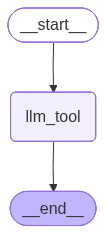

In [35]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
message=graph.invoke({"message":"what is 2 plus 2"})

In [42]:
for i in message["message"]:
    i.pretty_print()


================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fc_5eab19f0-55dc-4904-ba6d-0b6bb0e30091)
 Call ID: fc_5eab19f0-55dc-4904-ba6d-0b6bb0e30091
  Args:
    a: 2
    b: 2
